In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [40]:
from sklearn.model_selection import train_test_split

In [311]:
from xgboost import XGBClassifier
import xgboost as xgb

In [72]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, balanced_accuracy_score

## Get generated data

In [226]:
filter_names, colors = pickle.load(open("output/colors_f1.pkl", "rb"))

In [6]:
# load all component combinations that sum to unity
component_names, unity_surface_combinations = pickle.load(open("output/surface_combinations.pkl", "rb"))

In [11]:
unity_surface_combinations_df = pd.DataFrame(unity_surface_combinations, 
                                             columns=component_names)
unity_surface_combinations_df

,cloud,snow,sand,seawater,basalt,veg
0,0.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,0.00,0.05,0.95
2,0.00,0.00,0.00,0.00,0.10,0.90
3,0.00,0.00,0.00,0.00,0.15,0.85
4,0.00,0.00,0.00,0.00,0.20,0.80
...,...,...,...,...,...,...
53125,0.95,0.00,0.00,0.00,0.05,0.00
53126,0.95,0.00,0.00,0.05,0.00,0.00
53127,0.95,0.00,0.05,0.00,0.00,0.00
53128,0.95,0.05,0.00,0.00,0.00,0.00


In [35]:
colors_and_combinations = np.concatenate((unity_surface_combinations, colors), axis=1)
# main_df = pd.DataFrame(colors_and_combinations,
#                        columns=component_names + filter_names)

In [443]:
classifying_components = ['seawater','snow','cloud']
snrs = np.arange(5, 105, 5)
random_initializations = 100
xgb_clfs = []
ba_score_no_noise = np.zeros(len(classifying_components))
feature_importance = np.zeros((len(classifying_components), len(filter_names)))

for i, component in enumerate(classifying_components):
    # get training data and labels for machine learning
    X = colors
    y = (unity_surface_combinations_df[component] > 0).astype(int)
    
    X_train, X_test_no_noise, y_train, y_test= train_test_split(
                X, y, test_size=0.2, shuffle=True)
    
    # train XGBoost
    model = XGBClassifier(objective="binary:logistic", 
              tree_method = "auto",
              scale_pos_weight = len(y_train[y_train == 0])/len(y_train[y_train > 0]),
    #                       gpu_id = 0, 
              use_label_encoder=False
              eval_metric=balanced_accuracy_score)
    model.fit(X_train, y_train)
    
    # append to list of trained models
    xgb_clfs.append(model)
    
    # evaluate model at no noise
    y_pred_no_noise = model.predict(X_test_no_noise)
    
    # get balanced accuracy and feature importance
    ba_score_no_noise[i] = balanced_accuracy_score(y_test, y_pred_no_noise)
    feature_importance[i] = model.feature_importances_
    
    # evaluate at various snrs
    y_pred = np.zeros((len(snrs), random_initializations, y_test.shape[0]))
    ba_scores = np.zeros((len(snrs), random_initializations))
    
    for j, snr in enumerate(snrs):
        gaussian_scatter = 1/snr
        
        for k in range(random_initializations):
            # add noise to testing dataset
            noise_array = X_test_no_noise*gaussian_scatter*np.random.standard_normal(X_test_no_noise.shape)
            X_test = X_test_no_noise + noise_array
            
            # predict
            y_pred[j, k] = model.predict(X_test)
            ba_scores[j, k] = balanced_accuracy_score(y_test, y_pred[j, k])
    
    # save data
    pickle.dump((model, y_test, snrs, y_pred_no_noise, y_pred, ba_score_no_noise[i], ba_scores), 
                open(f"output/result_{component}.pkl", "wb"))

pickle.dump((model, feature_importance), open(f"output/models_and_features.pkl", "wb"))

/home/dang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:59:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:02:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/dang/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:06:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


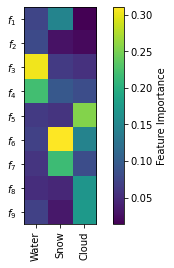

In [438]:
fig, ax = plt.subplots()
img = ax.imshow(feature_importance.T)

fig.colorbar(img, label='Feature Importance')

nice_component_names = ['Water', 'Snow', 'Cloud']
ax.set_xticks(np.arange(0, len(classifying_components), 1))
ax.set_xticklabels(nice_component_names, rotation=90)

nice_filter_names = [f"$f_{i+1}$" for i in range(len(filter_names))]
ax.set_yticks(np.arange(0, len(filter_names), 1))
ax.set_yticklabels(nice_filter_names);

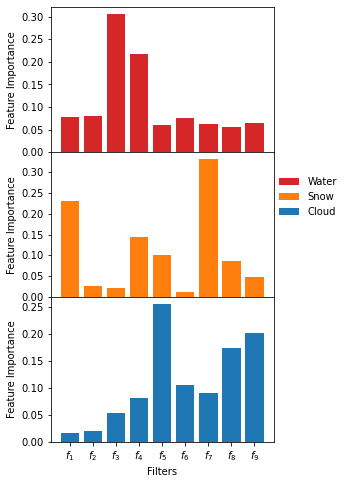

In [470]:
fig, axes = plt.subplots(nrows=feature_importance.shape[0], sharex=True, figsize=(4,8))
color_list = ['tab:red', 'tab:orange', 'tab:blue']
for i, ax in enumerate(axes):
    ax.bar(nice_filter_names, feature_importance[i,:], color=color_list[i], label=nice_component_names[i])
    ax.set_ylabel('Feature Importance')
fig.subplots_adjust( hspace=0 )
axes[2].set_xlabel('Filters')
fig.legend(frameon=False, bbox_to_anchor=(1.15, 0.6));


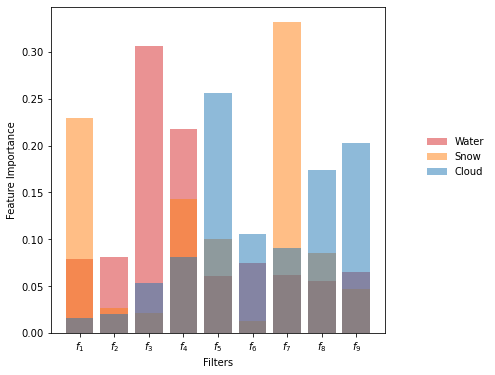

In [472]:
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(6,6))
color_list = ['tab:red', 'tab:orange', 'tab:blue']
for i in range(feature_importance.shape[0]):
    ax.bar(nice_filter_names, feature_importance[i,:], 
           color=color_list[i], label=nice_component_names[i],
           alpha=0.5)
    ax.set_ylabel('Feature Importance')
fig.subplots_adjust( hspace=0 )
ax.set_xlabel('Filters')
fig.legend(frameon=False, bbox_to_anchor=(1.15, 0.6));

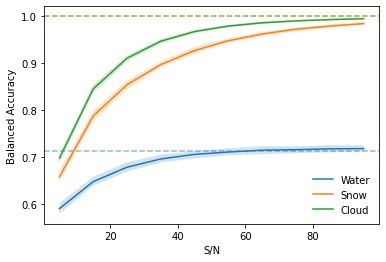

In [473]:
fig, ax = plt.subplots()
for i, component in enumerate(classifying_components):
    _, _, snrs, _, _, ba_score_no_noise, ba_scores = pickle.load(open(f"output/result_{component}.pkl", "rb"))
    lower, median, upper = np.percentile(ba_scores, (2.5, 50, 97.5), axis=1)
    plotline, = ax.plot(snrs, median, label=nice_component_names[i])
    ax.axhline(ba_score_no_noise, color=plotline.get_color(), linestyle='--', alpha=0.5)
    
    ax.fill_between(snrs, lower, upper, alpha=0.2)

ax.legend(frameon=False)
ax.set_xlabel('S/N')
ax.set_ylabel('Balanced Accuracy');
